🌿Preprocessing

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# load test data
mnist_path = "/home/ajay2425/rclass/mnist_dataset/mnist.npz" #main
with np.load(mnist_path) as data:
    x_test = data["x_test"]
    y_test = data["y_test"]
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# 1. Flatten
x_test_flat = x_test.reshape(x_test.shape[0], -1)
print(f"1. x_test_flat shape: {x_test_flat.shape}, y_test shape: {y_test.shape}")

# 2. Subsets
subset_size = 1000
x_test_subset = x_test_flat[:subset_size]
y_test_subset = y_test[:subset_size]
print(f"2. x_test_subset shape: {x_test_subset.shape}")

# 3. PCA
pca_model_path = "/home/ajay2425/rclass/models/models_grb/trained_pca.pkl" #main
# pca_model_path = "/home/ajay2425/rclass/models/add/trained_pca.pkl" # temp.
with open(pca_model_path, "rb") as file:
    pca = pickle.load(file)
print("(trained pca model loaded)")
# apply pca to the test data
x_test_pca = pca.transform(x_test_subset)  # Use the same pca model from training
print(f"3. x_test_pca shape: {x_test_pca.shape}")
variance = np.sum(pca.explained_variance_ratio_)
print(f"variance = {variance}")

# 4. Binarize
threshold_value = 0
x_test_norm = (x_test_pca > threshold_value).astype(int)
print(f"4. x_test_norm shape: {x_test_norm.shape}")

# # 4. Normalize
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# x_test_norm = scaler.fit_transform(x_test_pca)
# print(f"4. x_test_norm shape: {x_test_norm.shape}")

x_test shape: (10000, 28, 28), y_test shape: (10000,)
1. x_test_flat shape: (10000, 784), y_test shape: (10000,)
2. x_test_subset shape: (1000, 784)
(trained pca model loaded)
3. x_test_pca shape: (1000, 75)
variance = 0.9116844525507454
4. x_test_norm shape: (1000, 75)


🌿Generate multi-indices

In [2]:
def r_multi_indices(n, d):
    if n == 1:
        yield (d,)
    else:
        for k in range(d + 1):
            for c in r_multi_indices(n - 1, k):
                yield (d - k, *c)

def generate_multi_indices(n, d):
    from itertools import chain
    return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))

import pickle
import os
models_dir = "/home/ajay2425/rclass/models/models_grb/"
# models_dir = "/home/ajay2425/rclass/models/add/" #temp.
# Load the model for the current digit
model_path = f"{models_dir}/classifier_0.pkl"
with open(model_path, "rb") as file:
    model = pickle.load(file)
# Extract model parameters
n_components = model["n_components"]
d = model["degree"]
c = generate_multi_indices(n_components, d)
print(f"no_of_coeff =", len(c))

no_of_coeff = 76


🌿Generate polynomials

In [3]:
import numpy as np
def construct_G_H_matrices(x_test_norm, n, d):
    num_data_points = x_test_norm.shape[0]
    multi_indices = generate_multi_indices(n, d)
    num_coefficients = len(multi_indices)

    # Initialize G and H matrices
    G = []
    H = []

    # Construct G and H using multi-indices
    for i in range(num_data_points):
        G_row = []
        H_row = []
        for idx in multi_indices:
            term = np.prod([x_test_norm[i, k] ** idx[k] for k in range(n)])
            G_row.append(term)
            H_row.append(term)
        G.append(G_row)
        H.append(H_row)

    # Convert G and H to NumPy arrays
    G = np.array(G)
    H = np.array(H)

    # # Normalize G and H row-wise for numerical stability
    # G = G / np.linalg.norm(G, axis=1, keepdims=True)
    # H = H / np.linalg.norm(H, axis=1, keepdims=True)

    return G, H, multi_indices

🌿Load saved models

In [4]:
import pickle
import os

models_dir = "/home/ajay2425/rclass/models/models_grb/"
# models_dir = "/home/ajay2425/rclass/models/add/" #temp.

# Load all classifiers into memory
classifiers = {}
for digit in range(10):
    model_path = f"{models_dir}/classifier_{digit}.pkl"
    if os.path.exists(model_path):
        with open(model_path, "rb") as file:
            classifiers[digit] = pickle.load(file)
    else:
        print(f"Model for digit {digit} not found!")

# print(f"Loaded classifiers for digits: {list(classifiers.keys())}")

🌿Test

In [5]:
from sklearn.metrics import accuracy_score

# Initialize an array to store predictions
predictions = []

# Loop through each test sample
for i, test_samples in enumerate(x_test_norm):
    confidence_scores = []

    # Pass the test sample through each classifier
    for digit in range(10):

        # Load the model for the current digit
        model_path = f"{models_dir}/classifier_{digit}.pkl"
        with open(model_path, "rb") as file:
            model = pickle.load(file)
        # Extract model parameters
        alpha = model["alpha"]
        beta = model["beta"]
        theta = model["theta"]
        multi_indices = model["multi_indices"]

        test_sample_array = np.array([test_samples])

        # Compute the rational function value for the current classifier
        G, H, _ = construct_G_H_matrices(test_sample_array, model["n_components"],  model["degree"])
        numerator = np.dot(G[0], alpha)
        denominator = np.dot(H[0], beta)
        # if np.abs(denominator) < 1e-8:
        if np.abs(denominator) == 0:
            denominator = 1e-8  # to prevent division by zero
        rational_value = numerator / denominator

        # Append the confidence score for this classifier
        confidence_scores.append(rational_value)

    # Determine the predicted digit (index of the highest confidence score)
    predicted_digit = np.argmax(confidence_scores)
    predictions.append(predicted_digit)

    # # Debugging (optional): Print the confidence scores
    # print(f"Test Sample {i}: Confidence Scores = {confidence_scores}, Predicted Digit = {predicted_digit}")

#-----------------------------------------
# Evaluate accuracy
accuracy = accuracy_score(y_test_subset, predictions)
print(f"Overall Testing Accuracy: {accuracy * 100:.2f}%")

# # Optional: Save predictions and confidence scores for further analysis
# results = {"predictions": predictions, "confidence_scores": confidence_scores}
# with open("testing_results.pkl", "wb") as file:
#     pickle.dump(results, file)

Overall Testing Accuracy: 34.90%


🌿Test with actual Image

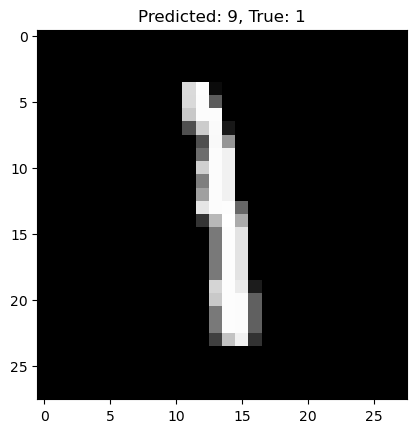

In [6]:
import matplotlib.pyplot as plt
import numpy as np

index_to_visualize = 29

# predicted digit for this index
predicted_digit = predictions[index_to_visualize]

# true digit for this index
true_digit = y_test_subset[index_to_visualize]

# Reshape the flattened image back to its original shape (28x28)
image = x_test_subset[index_to_visualize].reshape(28, 28)

# Plot the image
plt.imshow(image, cmap='gray')  # Use 'gray' colormap for MNIST
plt.title(f"Predicted: {predicted_digit}, True: {true_digit}")
plt.show()

🌿Accuracy Plot

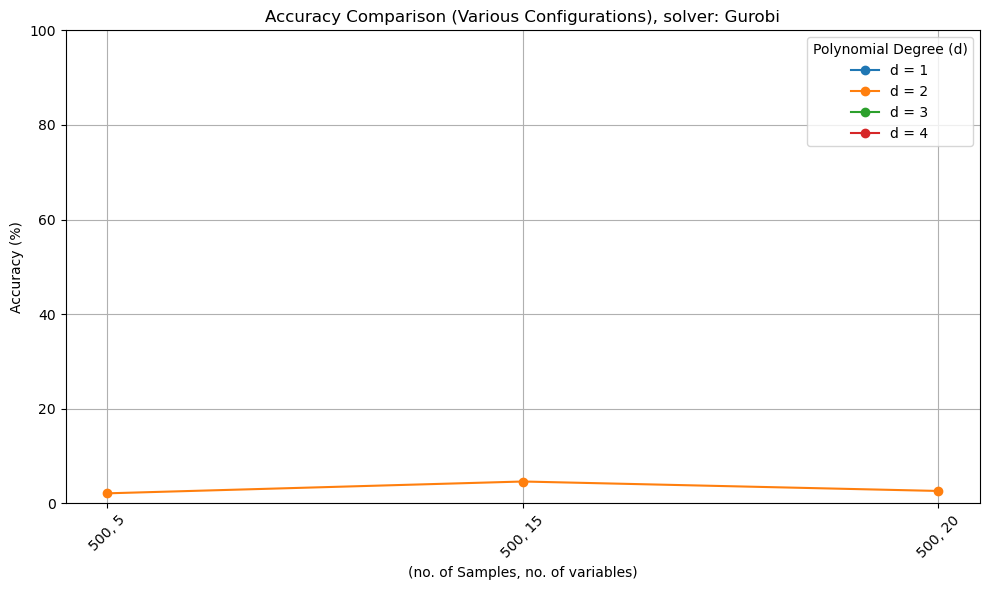

In [7]:
import matplotlib.pyplot as plt

# Data storage for visualization
results = {
    1: {  # d = 1
        # (500, 5): 20.60,
        # (500, 10): 16.80,
        # (1000, 10): 51.20,
        # (2000, 10): 13.30,
        # (3000, 10): 17.57,
    },
    2: {  # d = 2
        (500, 5): 2.1,
        (500, 15): 4.6,
        (500, 20): 2.6,
        # (2000, 10): 60.55,
        # (3000, 10): 65.37,
        # (4000, 10): 82.42,
        # (5000, 10): 54,
        # (6000, 10): 55.20,
    },
    3: {  # d = 3
        # (500, 5): 60.60,
    },
    4: {  # d = 4
        #(500, 5): 62.00,
    },
}

# Visualization function
def plot_results(results):
    plt.figure(figsize=(10, 6))
    for d, values in results.items():
        samples_components = list(values.keys())
        accuracies = list(values.values())
        labels = [f"{samples}, {components}" for samples, components in samples_components]

        # Plot each degree d
        plt.plot(labels, accuracies, marker='o', label=f"d = {d}")

    # Add plot details
    plt.title("Accuracy Comparison (Various Configurations), solver: Gurobi")
    plt.xlabel("(no. of Samples, no. of variables)")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Polynomial Degree (d)")
    plt.tight_layout()
    plt.show()

# Plot the results
plot_results(results)